In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error,root_mean_squared_error,r2_score
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import backtesting_sarimax, grid_search_sarimax
from skforecast.model_selection import TimeSeriesFold
from statsmodels.tsa.statespace.sarimax import SARIMAX


import warnings
warnings.filterwarnings('ignore')

c:\Users\Abdon.RAMIREZ-BRICEN\OneDrive - Akkodis\Desktop\Proyecto ML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv(r'..\..\data\processed\Merch_ML.csv',index_col='Order_ID')
df.head()

,Order_Date,Buyer_Age,Sales_Price,Shipping_Charges,Sales_per_Unit,Quantity,Total_Sales,Rating,Product_ID,Order_Location,International_Shipping,Buyer_Gender,Product_Category_Clothing,Product_Category_Ornaments,Product_Category_Other
Order_ID,,,,,,,,,,,,,,,
189440,2024-07-21,30,100,0,100,1,100,4,0,15,0,1,1.0,0.0,0.0
187385,2024-07-20,32,100,0,100,1,100,3,0,6,0,1,1.0,0.0,0.0
181844,2024-07-21,26,9,40,49,1,49,2,1,1,1,0,0.0,0.0,1.0
197934,2024-08-19,28,9,0,9,2,18,3,1,18,0,1,0.0,0.0,1.0
122470,2024-01-06,19,10,0,10,3,30,5,2,11,0,0,0.0,0.0,1.0


In [4]:
resultados = {}

# Función para evaluar un modelo y guardar resultados
def evaluar_modelo(nombre,y_pred,y_test):
  
    # Calcular métricas
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Guardar en el diccionario
    resultados[nombre] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}

In [5]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

In [6]:
# Asegurar que las fechas sean de tipo datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

df_daily = df.groupby(df['Order_Date'].dt.to_period('D'))['Total_Sales'].sum().reset_index()

df_daily['Order_Date'] = df_daily['Order_Date'].dt.to_timestamp()

df_daily.head()


,Order_Date,Total_Sales
0,2023-11-05,1954
1,2023-11-06,2007
2,2023-11-07,2652
3,2023-11-08,1651
4,2023-11-09,1982


In [7]:
df_daily.set_index('Order_Date',inplace=True)

In [8]:
df_daily.sort_values(by='Order_Date')

,Total_Sales
Order_Date,
2023-11-05,1954
2023-11-06,2007
2023-11-07,2652
2023-11-08,1651
2023-11-09,1982
...,...
2024-10-31,2197
2024-11-01,4307
2024-11-02,1151


In [9]:
df_daily = df_daily.asfreq('D')

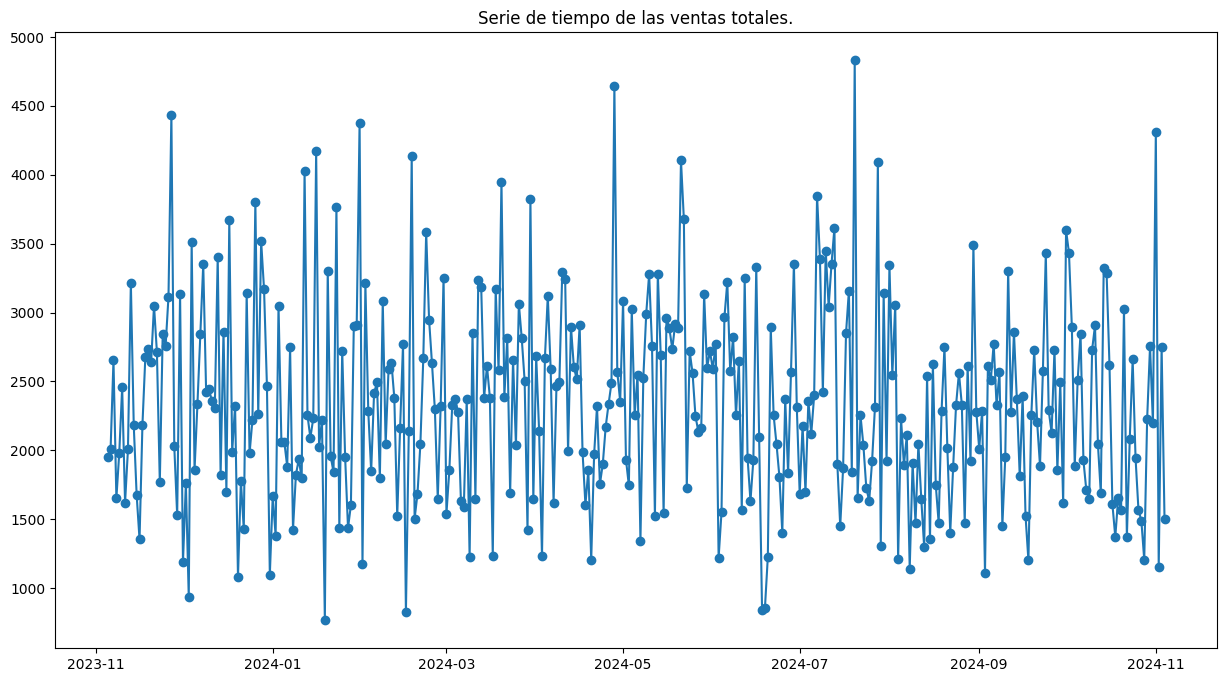

In [10]:
plt.figure(figsize=(15,8))
plt.plot(df_daily.index, df_daily['Total_Sales'], label='Ventas Reales', marker='o')
plt.title('Serie de tiempo de las ventas totales.');

In [11]:
print(type(df_daily.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_daily['Total_Sales'])
print(f"p-value de Dickey-Fuller: {result[1]:.5f}")

# Interpretación:
if result[1] < 0.05:
    print("La serie es estacionaria (p-value < 0.05)")
else:
    print("La serie NO es estacionaria (p-value >= 0.05), necesitamos diferenciación.")


p-value de Dickey-Fuller: 0.00000
La serie es estacionaria (p-value < 0.05)


In [13]:
print(f"Número de observaciones en df_monthly: {len(df_daily)}")


Número de observaciones en df_monthly: 366


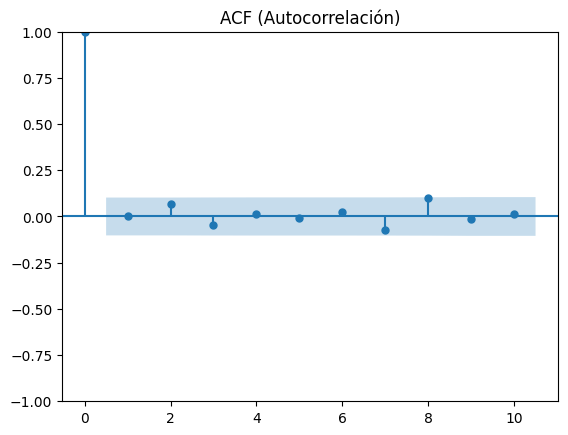

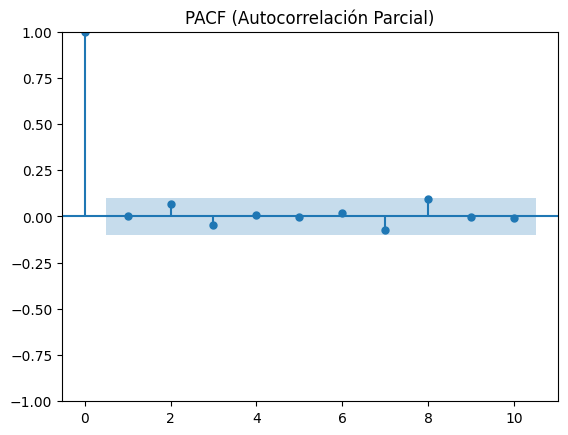

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_daily['Total_Sales'].dropna(), lags=10)  # Ver ACF para determinar `q`
plt.title('ACF (Autocorrelación)')

plot_pacf(df_daily['Total_Sales'].dropna(), lags=10)  # Ver PACF para determinar `p`
plt.title('PACF (Autocorrelación Parcial)')

plt.show()


In [15]:
train = df_daily.iloc[:290]
test = df_daily.iloc[290:]

print(f"Tamaño de Train: {len(train)} dias")
print(f"Tamaño de Test: {len(test)} dias")


Tamaño de Train: 290 dias
Tamaño de Test: 76 dias


In [16]:
model = ARIMA(train['Total_Sales'], order=(1,0,1)).fit()

# Hacer predicciones en el conjunto de Test
test_pred = model.forecast(steps=len(test))

# Calcular el error en Test
mae = mean_absolute_error(test, test_pred)
print(f"Error MAE en Test: {mae:.2f}")
evaluar_modelo('ARIMA(1,0,1)',y_pred=test_pred, y_test=test)

Error MAE en Test: 540.38


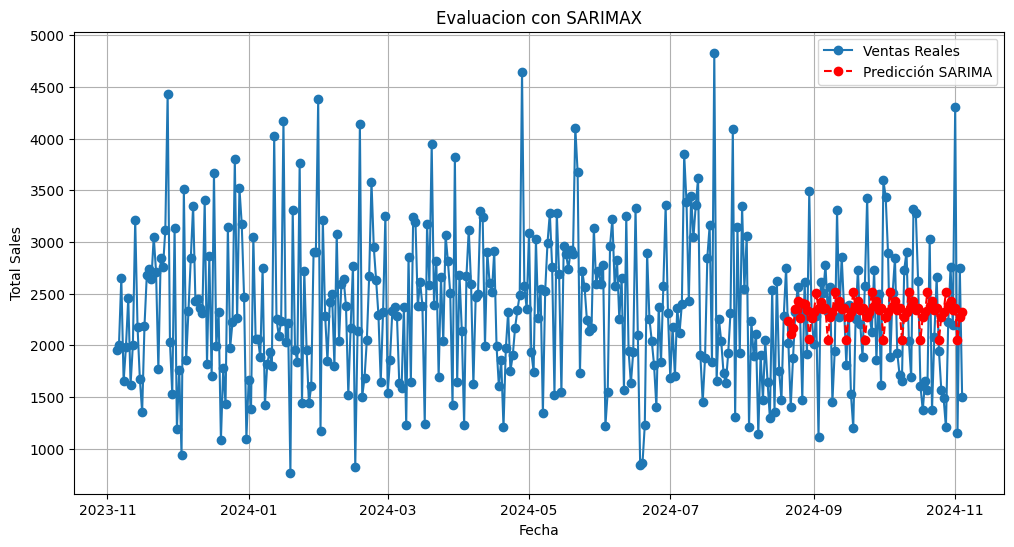

In [17]:
plt.figure(figsize=(12,6))

# Graficar las ventas reales
plt.plot(df_daily.index, df_daily['Total_Sales'], label='Ventas Reales', marker='o')

# Graficar predicciones en Test
plt.plot(test.index, test_pred, label='Predicción en Test', linestyle='dashed', marker='o', color='red')

# Configurar la gráfica
plt.xlabel('Fecha')
plt.ylabel('Total Sales')
plt.title('Evaluación de ARIMA en el Conjunto de Test')
plt.legend()
plt.grid()
plt.show()


In [18]:
model_sarima = SARIMAX(train['Total_Sales'], order=(1,0,1), seasonal_order=(1,1,1,8)).fit()
test_pred_sarima = model_sarima.forecast(steps=len(test))

plt.figure(figsize=(12,6))
plt.plot(df_daily.index, df_daily['Total_Sales'], label='Ventas Reales', marker='o')
plt.plot(test.index, test_pred_sarima, label='Predicción SARIMA', linestyle='dashed', marker='o', color='red')
plt.xlabel('Fecha')
plt.ylabel('Total Sales')
plt.title('Evaluacion con SARIMAX')
plt.legend()
plt.grid()
plt.show();

MAE: 542.30
RMSE: 676.03


In [19]:
mae = mean_absolute_error(test,test_pred_sarima)
rmse = root_mean_squared_error(test,test_pred_sarima)
evaluar_modelo('SARIMAX(1,0,1,8)',y_pred=test_pred_sarima, y_test=test)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

Number of models compared: 8.


params grid: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (1, 0, 1), 'seasonal_order': (1, 1, 0, 8)}
  Backtesting metric: 566.8295464756687



,params,mean_absolute_error,order,seasonal_order
0,"{'order': (1, 0, 1), 'seasonal_order': (1, 1, ...",566.829546,"(1, 0, 1)","(1, 1, 0, 8)"
1,"{'order': (1, 0, 1), 'seasonal_order': (0, 1, ...",610.989333,"(1, 0, 1)","(0, 1, 0, 8)"
2,"{'order': (1, 0, 1), 'seasonal_order': (0, 1, ...",649.560113,"(1, 0, 1)","(0, 1, 1, 8)"
3,"{'order': (1, 0, 1), 'seasonal_order': (1, 1, ...",652.365289,"(1, 0, 1)","(1, 1, 1, 8)"
4,"{'order': (1, 0, 1), 'seasonal_order': (0, 0, ...",692.746812,"(1, 0, 1)","(0, 0, 1, 8)"


In [20]:
forecaster = ForecasterSarimax(
    regressor=Sarimax(
        order=(1, 1, 0),  # Hiperparámetros del modelo (p, d, q)
        seasonal_order=(0, 0, 0, 30),  # Hiperparámetros estacionales (P, D, Q, S)
        maxiter=200  # Número máximo de iteraciones
    )
)

# Definir la validación cruzada con TimeSeriesFold
cv = TimeSeriesFold(
    steps=12,
    initial_train_size=len(df_daily) - 12,  
    refit=True,  
    fixed_train_size=False  
)

metrica, predicciones_sarimax_f = backtesting_sarimax(
    forecaster=forecaster,
    y=df_daily['Total_Sales'],  # La variable objetivo (ventas)
    cv=cv,
    metric='mean_absolute_error',
    suppress_warnings_fit=True,
    verbose=True,
    show_progress=True
)

print(f'Metrica: {metrica}')
print(f'Predicciones:\n{predicciones_sarimax_f.head()}')

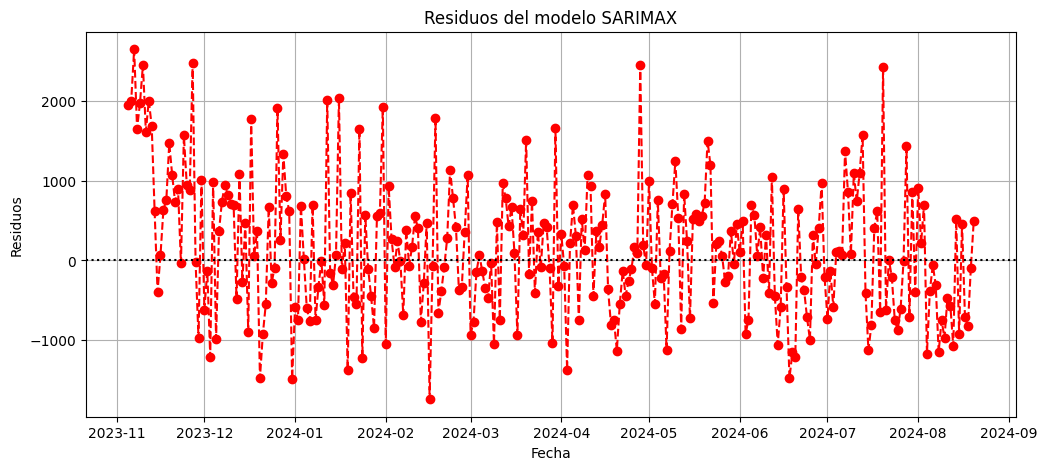

In [21]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 0, 1),
                                maxiter=500
                            )
             )

p_range = [1]
d_range = [0]
q_range = [1]
P_range = range(2) 
D_range = range(2) 
Q_range = range(2) 
m_values = [8]
# Generar todas las combinaciones posibles para order y seasonal_order
param_grid = {
    'order': [(p, d, q) for p, d, q in product(p_range, d_range, q_range)],
    'seasonal_order': [(P, D, Q, m) for P, D, Q, m in product(P_range, D_range, Q_range, m_values)]
}

cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(df_daily) - 12,
        refit              = True,
        fixed_train_size   = False,
    )


resultados_grid = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = df_daily['Total_Sales'],
                        param_grid            = param_grid,
                        cv                    = cv,
                        metric                = 'mean_absolute_error',
                        return_best           = True,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )
resultados_grid.head()

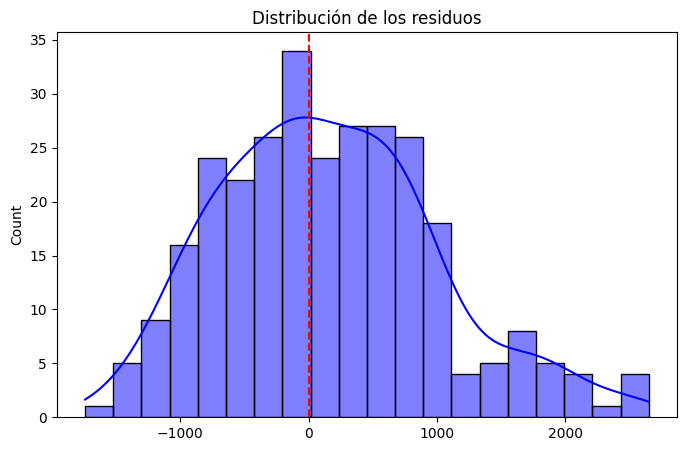

In [22]:
# Obtener los residuos
residuals = model_sarima.resid

In [23]:
plt.figure(figsize=(12,5))
plt.plot(residuals, marker='o', linestyle='dashed', color='red')
plt.axhline(y=0, color='black', linestyle='dotted')
plt.title('Residuos del modelo SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.grid()
plt.show()


Estadística=0.9820, p-valor=0.0010
❌ Los residuos NO siguen una distribución normal (p < 0.05)


In [24]:
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=20, kde=True, color='blue')
plt.axvline(x=0, color='red', linestyle='dashed')
plt.title('Distribución de los residuos')
plt.show()

In [25]:
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print(f'Estadística={stat:.4f}, p-valor={p:.4f}')

if p > 0.05:
    print("✅ Los residuos siguen una distribución normal (p > 0.05)")
else:
    print("❌ Los residuos NO siguen una distribución normal (p < 0.05)")
